Name: Sharryl Seto (1005523)

Date: 06/04/2024

In [313]:
# importing libraries
import random
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# How to measure the bias?
- Compute the difference between similarities of a gender neutral word (eg., Doctor) from gender-specific words (eg. Male and Female).
  - Similarity score: Cosine angle, Euclidean distance
- Compute the difference between prediction scores when a gender-specific word is switched to a word specifying some other gender.

#Solve: Gender Debiasing Contextualised Embedding

In [320]:
# from transformers import pipeline
# # import pre-trained BERT
# bert = pipeline('fill-mask', model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [321]:
# # checking the bias given on https://huggingface.co/learn/nlp-course/en/chapter1/8
# result = bert("This man works as a [MASK].")
# print([r["token_str"] for r in result])

# result = bert("This woman works as a [MASK].")
# print([r["token_str"] for r in result])

['carpenter', 'lawyer', 'farmer', 'businessman', 'doctor']
['nurse', 'maid', 'teacher', 'waitress', 'prostitute']


In [280]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [295]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [339]:
# just for fun to see the bias...
# Define gendered words and occupations
gendered_words = ["he", "him", "his", "she", "her", "hers"]
occupations = ["doctor", "nurse", "engineer", "teacher", "dancer", "carpenter"]

# Tokenize gendered words and occupations
tokens_gendered = tokenizer(gendered_words, return_tensors='pt', padding=True, truncation=True)
tokens_occupations = tokenizer(occupations, return_tensors='pt', padding=True, truncation=True)

# Obtain embeddings from BERT model
with torch.no_grad():
    outputs_gendered = model(**tokens_gendered)
    outputs_occupations = model(**tokens_occupations)

# Extract the embeddings of gendered words and occupations
embeddings_gendered = outputs_gendered.last_hidden_state.mean(dim=1)  # Shape: (6, 768)
embeddings_occupations = outputs_occupations.last_hidden_state.mean(dim=1)  # Shape: (6, 768)

# Calculate cosine similarity between gendered words and occupations
gender_occupation_similarities = cosine_similarity(embeddings_gendered, embeddings_occupations)

# Print gender-occupation similarities
print("Gender-Occupation Similarities:")
for i, gender_word in enumerate(gendered_words):
    for j, occupation in enumerate(occupations):
        similarity = gender_occupation_similarities[i][j]
        print(f"{gender_word} - {occupation}: {similarity}")

Gender-Occupation Similarities:
he - doctor: 0.8717045783996582
he - nurse: 0.8466383814811707
he - engineer: 0.6631385684013367
he - teacher: 0.7883745431900024
he - dancer: 0.7576519250869751
he - carpenter: 0.8519845008850098
him - doctor: 0.8801813125610352
him - nurse: 0.843268871307373
him - engineer: 0.6242530941963196
him - teacher: 0.7855677008628845
him - dancer: 0.7525762319564819
him - carpenter: 0.8333390951156616
his - doctor: 0.8854888677597046
his - nurse: 0.8519873023033142
his - engineer: 0.6360336542129517
his - teacher: 0.7882104516029358
his - dancer: 0.7497940063476562
his - carpenter: 0.8357086181640625
she - doctor: 0.8549598455429077
she - nurse: 0.8521134257316589
she - engineer: 0.6866497993469238
she - teacher: 0.7898225784301758
she - dancer: 0.7686833143234253
she - carpenter: 0.8644381761550903
her - doctor: 0.8859351873397827
her - nurse: 0.8690469264984131
her - engineer: 0.6479382514953613
her - teacher: 0.7969503402709961
her - dancer: 0.7596569061279

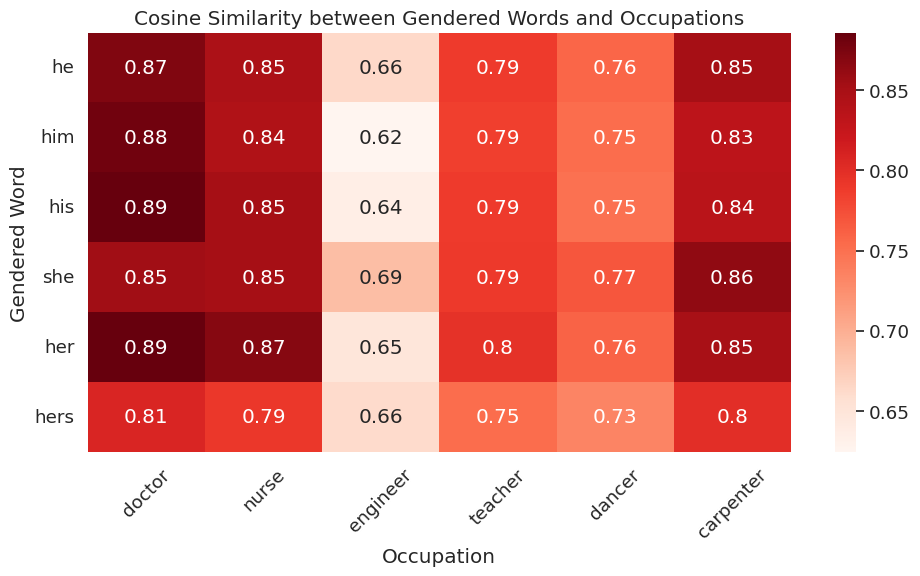

In [340]:
# Set up the plot to see the discrepancies
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
sns.heatmap(gender_occupation_similarities, annot=True, xticklabels=occupations, yticklabels=gendered_words, cmap="Reds")
plt.title("Cosine Similarity between Gendered Words and Occupations")
plt.xlabel("Occupation")
plt.ylabel("Gendered Word")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We identify a subspace where BERT encodes gender information.

## Step 1: We collect a set of n-gender word pairs such as:

(fi, mi) ∈ {(Queen, King), (She, He), (Woman, Man), (Girl, Boy), (Actress, Actor)...}

Taken from: https://www.proofreadingservices.com/pages/nouns-of-opposite-gender


The set below is in (mi, fi) format.

In [341]:
gender_word_pairs = {
    ("abbot", "abbess"),("actor",	"actress"),("author",	"authoress"),
    ("bachelor",	"spinster"),("baron",	"baroness"),("benefactor",	"benefactress"),
    ("boar",	"sow"),("boy",	"girl"),("groom",	"bride"),("brother",	"sister"),
    ("buck",	"doe"),("bull",	"cow"),("cock",	"hen"),("conductor",	"conductress"),
    ("count",	"countess"),("czar",	"czarina"),("dad",	"mum"),("daddy",	"mummy"),
    ("drake",	"duck"),("drone",	"bee"),("duke",	"duchess"),("emperor",	"empress"),
    ("enchanter", "enchantress"),("father",	"mother"),("fox",	"vixen"),
    ("gander",	"goose"),("gentleman",	"lady"),("giant",	"giantess"),
    ("god",	"goddess"),("grandfather",	"grandmother"),("he-goat",	"she-goat"),
    ("heir",	"heiress"),("hero",	"heroine"),("host",	"hostess"),("hunter",	"huntress"),
    ("husband",	"wife"),("king",	"queen"),("landlord", "landlady"),
    ("lion",	"lioness"),("lord",	"lady"),("man",	"woman"),("manservant",	"maidservant"),
    ("master",	"mistress"), ("milkman",	"milkmaid"), ("monk",	"nun"),
    ("murderer",	"murderess"),("nephew",	"niece"),("patron",	"patroness"),
    ("peacock",	"peahen"),("peer",	"peeress"),("poet",	"poetess"),
    ("policeman",	"policewoman"),("priest",	"priestess"),("prince",	"princess"),
    ("prophet",	"prophetess"),("ram",	"ewe"),("rooster", "hen"),
    ("shepherd",	"shepherdess"),("signor",	"signora"),("sir",	"madam"),
    ("son",	"daughter"),("songster",	"songstress"),("stag",	"hind"),
    ("stallion",	"mare"), ("steward",	"stewardess"), ("sultan",	"sultana"),
    ("tempter",	"temptress"),("tiger",	"tigress"),("traitor",	"traitress"),
    ("uncle",	"aunt"),("viscount",	"viscountess"),("waiter",	"waitress"),
    ("wizard",	"witch")
}
print(f"Length of Gender Pair Set: {len(gender_word_pairs)}")

Length of Gender Pair Set: 73


How does BERT tokenize text? After researching...

1. Split each word of sentence into sub-word tokens (word piece).
2. Encode these tokens into IDs.
3. Set add_special_tokens parameter to ‘True’ to add special token like SEP and CLS in tokenized text. This is a good practice!
- SEP : is used for separating different segments or sentences within a single input sequence + inserted between two sentences or segments
- CLS : is the first token in every input sequence. It is used to represent the entire input sequence in a single vector and called as the “CLS” embedding.

## Step 2: Feed them to BERT and obtain corresponding word embeddings.
ui is word vector for fi and vi is word vector for mi.

What are word embeddings?

- capture the semantic meaning of words
- reduce dimensionality
- add contextual information
- promote efficient learning by transferring linguistic knowledge via pre-trained embeddings
- **represent individual words as vectors**

In [342]:
mi, fi = zip(*gender_word_pairs)

In [343]:
print(len(mi))
print(len(fi))

73
73


In [453]:
# Find the maximum token length among all words
max_length = max(max(len(tokenizer.tokenize(word)) for word in mi),
                 max(len(tokenizer.tokenize(word)) for word in fi))

# Tokenize and encode text using batch_encode_plus with specified maximum length
m_encoding = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=mi,  # List of input texts
    padding='max_length',         # Pad to the maximum sequence length
    max_length=max_length,        # Specify the maximum sequence length
    truncation=True,              # Truncate to the maximum sequence length if necessary
    return_tensors='pt',          # Return PyTorch tensors
    add_special_tokens=True,      # Add special tokens CLS and SEP
)

f_encoding = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=fi,  # List of input texts
    padding='max_length',         # Pad to the maximum sequence length
    max_length=max_length,        # Specify the maximum sequence length
    truncation=True,              # Truncate to the maximum sequence length if necessary
    return_tensors='pt',          # Return PyTorch tensors
    add_special_tokens=True,      # Add special tokens CLS and SEP
)

m_input_ids = m_encoding['input_ids']
m_attention_mask = m_encoding['attention_mask']  # Attention mask

f_input_ids = f_encoding['input_ids']  # Token IDs
# print(f"Input ID: {input_ids}")
f_attention_mask = f_encoding['attention_mask']  # Attention mask
# print(f"Attention mask: {attention_mask}")

In [454]:
print(max_length)
print(m_input_ids.shape)
print(f_input_ids.shape)

4
torch.Size([73, 4])
torch.Size([73, 4])


In [455]:
# Generate embeddings using BERT model
with torch.no_grad():
    m_outputs = model(m_input_ids, attention_mask=m_attention_mask)
    m_word_embeddings = m_outputs.last_hidden_state   # This contains the embeddings
    f_outputs = model(f_input_ids, attention_mask=f_attention_mask)
    f_word_embeddings = f_outputs.last_hidden_state  # This contains the embeddings

# Output the shape of word embeddings
print(f"Shape of Male Word Embeddings: {m_word_embeddings.shape}")
print(f"Shape of Female Word Embeddings: {f_word_embeddings.shape}")

Shape of Male Word Embeddings: torch.Size([73, 4, 768])
Shape of Female Word Embeddings: torch.Size([73, 4, 768])


This means we have embeddings for 73 words, each consisting of 4 subtokens, and each subtoken embedding having a dimension of 768.

In [456]:
print(f"Shape of Input IDs: {f_input_ids.shape}")

Shape of Input IDs: torch.Size([73, 4])


In [457]:
# # see what the text looks like
# # Decode the token IDs back to text
# decoded_text = tokenizer.decode(m_input_ids[5], skip_special_tokens=True)
# #print decoded text
# print(f"Decoded Text: {decoded_text}")
# # Tokenize the text again for reference
# tokenized_text = tokenizer.tokenize(decoded_text)
# #print tokenized text
# print(f"tokenized Text: {tokenized_text}")
# # Encode the text
# encoded_text = tokenizer.encode(tokenized_text, return_tensors='pt')  # Returns a tensor
# # Print encoded text
# print(f"Encoded Text: {encoded_text}")

Plot graph to see vectors

<ipython-input-458-77450acc7a90>:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'bo', linestyle="--", c=c)


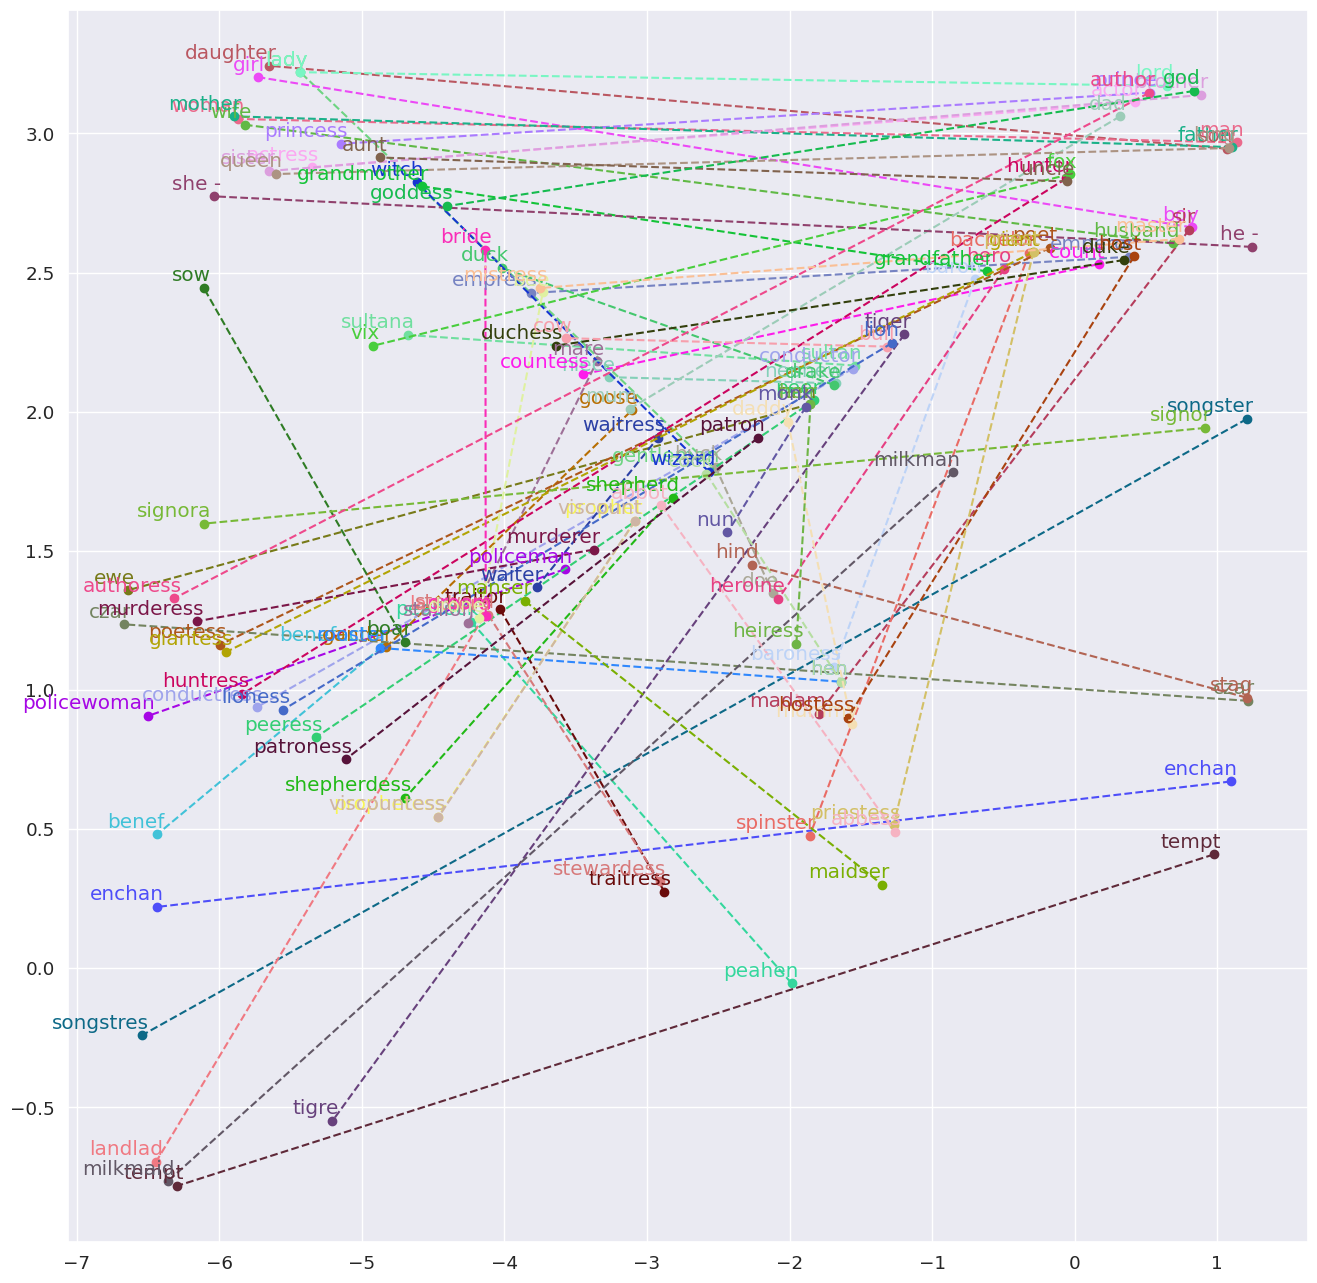

In [458]:
m_labels = []
m_tokens = []
f_labels = []
f_tokens = []

# to speed up the process, let's limit to the first 100 elements
count = 0
for i in range(len(m_input_ids)):
    if count < 100:
        # store the word embeddings of the words
        # tokens.append(m_input_ids[i])
        # keep track of the labels too so that we can plot it in the graph below
        m_labels.append(tokenizer.decode(m_input_ids[i], skip_special_tokens=True))
        f_labels.append(tokenizer.decode(f_input_ids[i], skip_special_tokens=True))
        count = count+1

m_tokens = np.array(m_input_ids)
f_tokens = np.array(f_input_ids)
# define the parameters of the tsne model
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

# for the embeddings of our tokes to the tsne model
m_new_values = tsne_model.fit_transform(m_tokens)
f_new_values = tsne_model.fit_transform(f_tokens)

plt.figure(figsize=(16, 16))
# Now let's plot the tsne projects for each of the m and f tokens in 2D
m_x = []
m_y = []
f_x = []
f_y = []
for value in m_new_values:
    m_x.append(value[0])
    m_y.append(value[1])
for value in f_new_values:
    f_x.append(value[0])
    f_y.append(value[1])

for i in range(len(m_x)):
    # plotting m point
    c=np.random.rand(3,)
    # now let's draw line between the 2 respective points
    x_values = [m_x[i], f_x[i]]
    y_values = [m_y[i], f_y[i]]
    plt.plot(x_values, y_values, 'bo', linestyle="--", c=c)

    # annotate m label
    plt.annotate(m_labels[i],
                  xy=(m_x[i], m_y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  c=c)

    # annotate f label
    plt.annotate(f_labels[i],
                  xy=(f_x[i], f_y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  c=c)

plt.show()

## Step 3 & 4: Obtain a set of difference vectors {d1 , ..., dn }, where di = (vi − ui )
ui is word vector for fi and vi is word vector for mi.
(Each difference vector shows shift from female to male in vector space.)

In [459]:
diff_vector = (m_word_embeddings - f_word_embeddings)

Questions: Can we used it to find the directions (subspace) that encode gender information? i.e., do we know any algorithm that can help uncover the principal directions which explains
the most spread of vectors in {d1,...,dn}?

## Step 5: Compute PCs.
The 1st PC covers explains most variance in the difference vectors. Hence, we consider the gender subspace to be 1-dimensional with axis identified by 1st PC.

In [460]:
print(diff_vector.shape)

torch.Size([73, 4, 768])


In [461]:
from sklearn.decomposition import PCA

di_matrix = np.array(diff_vector)
reshaped_matrix = di_matrix.reshape(di_matrix.shape[0], -1)  # Shape: [73, 3072]
print(reshaped_matrix.shape)

pca = PCA(n_components=2)  # You can adjust the number of components as needed
principal_components = pca.fit_transform(reshaped_matrix)

(73, 3072)


In [462]:
# Analyze principal components
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.5091804  0.03580262]


PC1 explains approximately 50.92% of the variance in the data.
PC2 explains approximately 3.58% of the variance in the data.


## Step 6: Removing obtained gender direction during inference
From each word vector produced by BERT, we remove the component in PC1. This will reduce the gender-specific information from the BERT word embedding.

In [463]:
# Remove PC1 from the data
m_matrix = np.array(m_word_embeddings)
m_matrix = m_matrix.reshape(m_matrix.shape[0], -1)  # Shape: [73, 3072]
f_matrix = np.array(f_word_embeddings)
f_matrix = f_matrix.reshape(f_matrix.shape[0], -1)  # Shape: [73, 3072]

# male
m_principal_components = pca.fit_transform(m_matrix)
m_pc1_vector = pca.components_[0]  # PC1 vector
m_pc1_projection = np.outer(m_principal_components[:, 0], m_pc1_vector)  # Projection of data onto PC1
m_embedding_wo_pc1 = m_matrix - m_pc1_projection

# female
f_principal_components = pca.fit_transform(f_matrix)
f_pc1_vector = pca.components_[0]  # PC1 vector
f_pc1_projection = np.outer(f_principal_components[:, 0], f_pc1_vector)  # Projection of data onto PC1
f_embedding_wo_pc1 = f_matrix - f_pc1_projection

# Reshape data back to original shape if needed
m_data_wo_pc1_3D = m_embedding_wo_pc1.reshape(m_word_embeddings.shape)
f_data_wo_pc1_3D = f_embedding_wo_pc1.reshape(f_word_embeddings.shape)
print(m_data_wo_pc1_3D.shape)
print(m_data_wo_pc1_3D.dtype)
# Now data_without_pc1_3d contains the BERT model data with PC1 component removed

(73, 4, 768)
float32


In [475]:
print(m_embedding_wo_pc1.shape)

(73, 3072)


In [467]:
# # convert back to tensor
m_data_wo_pc1 = torch.tensor(m_data_wo_pc1_3D, dtype=torch.float32)
f_data_wo_pc1 = torch.tensor(f_data_wo_pc1_3D, dtype=torch.float32)
print(m_data_wo_pc1.shape)

torch.Size([73, 4, 768])


To check to see if there is difference. Get new token ids based on new embeddings and plot same graph. But due to size constraints, I am unable to do so.

In [481]:
# Get vocabulary embeddings from the model
batch_size = 32
vocabulary_embeddings = {}
for token in tokenizer.vocab.keys():
    token_id = tokenizer.encode(token, add_special_tokens=False)
    # Add padding to ensure all token sequences have the same length
    token_id += [0] * (batch_size - len(token_id))
    # Divide token ids into batches
    batches = [token_id[i:i+batch_size] for i in range(0, len(token_id), batch_size)]
    # Convert token ids to PyTorch tensors
    token_tensors = [torch.tensor(batch).unsqueeze(0) for batch in batches]
    with torch.no_grad():
        # Forward pass to obtain embeddings for each batch
        embeddings = []
        for token_tensor in token_tensors:
            outputs = model(input_ids=token_tensor)
            # Get the last layer embeddings
            batch_embeddings = outputs.last_hidden_state
            embeddings.append(batch_embeddings)
        # Concatenate embeddings from all batches
        token_embedding = torch.cat(embeddings, dim=1)
        # Average embeddings to obtain token-level embedding
        token_embedding = torch.mean(token_embedding, dim=1).squeeze().numpy()
    vocabulary_embeddings[token] = token_embedding

# Example word embeddings (replace this with your own embeddings)
word_embeddings = [...]  # Shape: (73, 768) assuming you've averaged over the subtokens

# Find nearest tokens in vocabulary for each word embedding
nearest_tokens = []
for embedding in m_embedding_wo_pc1:
    # Calculate cosine similarity between the word embedding and vocabulary embeddings
    similarities = []
    for vocab_embedding in vocabulary_embeddings.values():
        similarity = cosine_similarity([embedding], [vocab_embedding])[0][0]
        similarities.append(similarity)
    # Find index of the token with highest similarity
    nearest_token_index = np.argmax(similarities)
    # Get the corresponding token from the tokenizer
    nearest_token = list(vocabulary_embeddings.keys())[nearest_token_index]
    nearest_tokens.append(nearest_token)

print("Nearest tokens for each word embedding:")
for word, nearest_token in zip(words, nearest_tokens):
    print(f"{word}: {nearest_token}")

KeyboardInterrupt: 

In [472]:
m_labels = []
m_tokens = []
f_labels = []
f_tokens = []

# to speed up the process, let's limit to the first 100 elements
count = 0
for i in range(len(nearest_tokens)):
    if count < 100:
        # store the word embeddings of the words
        # tokens.append(m_input_ids[i])
        # keep track of the labels too so that we can plot it in the graph below
        m_labels.append(tokenizer.decode(nearest_tokens[i], skip_special_tokens=True))
        f_labels.append(tokenizer.decode(nearest_tokens2[i], skip_special_tokens=True))
        count = count+1

m_tokens = np.array(m_data_wo_pc1_3D)
f_tokens = np.array(f_data_wo_pc1_3D)
# define the parameters of the tsne model
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

# for the embeddings of our tokes to the tsne model
m_new_values = tsne_model.fit_transform(m_tokens)
f_new_values = tsne_model.fit_transform(f_tokens)

plt.figure(figsize=(16, 16))
# Now let's plot the tsne projects for each of the m and f tokens in 2D
m_x = []
m_y = []
f_x = []
f_y = []
for value in m_new_values:
    m_x.append(value[0])
    m_y.append(value[1])
for value in f_new_values:
    f_x.append(value[0])
    f_y.append(value[1])

for i in range(len(m_x)):
    # plotting m point
    c=np.random.rand(3,)
    # now let's draw line between the 2 respective points
    x_values = [m_x[i], f_x[i]]
    y_values = [m_y[i], f_y[i]]
    plt.plot(x_values, y_values, 'bo', linestyle="--", c=c)

    # annotate m label
    plt.annotate(m_labels[i],
                  xy=(m_x[i], m_y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  c=c)

    # annotate f label
    plt.annotate(f_labels[i],
                  xy=(f_x[i], f_y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  c=c)

plt.show()

TypeError: float() argument must be a string or a real number, not 'ellipsis'